# Coupler design using coupled mode theory

In this notebook, we are going to explore how to tailor the length of near-field directional couplers via coupled mode analysis.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from shapely.geometry import Polygon
from skfem import Basis, ElementTriP0
from skfem.io import from_meshio

from femwell.mesh import mesh_from_OrderedDict
from femwell.mode_solver import compute_modes, plot_mode

from phodex.materials import n_sio2, n_si3n4, n_si

The trick here is that the coupling length to achieve a certain coupling ratio is given by:
$$ L = \frac{\lambda_0}{\pi \Delta n} \text{sin}^{-1}\left(\sqrt{\frac{P_1}{P_0}}\right) \quad ,$$
where the coupling coefficient $c = \frac{P_1}{P_0}$.

In [2]:
def coupler_length(c, l0, dn):
    return l0 / (np.pi * dn) * np.arcsin(np.sqrt(c))

## Silicon coupler

First, we will tailor the length of the silicon coupler that we designed in [coupler_2x2_optimization.ipynb](https://github.com/mrbaozi/phodex/blob/main/examples/gdsfactory/coupler_2x2_optimization.ipynb).

There, we determined that the gap width of a 8μm long directional coupler should be 117nm for a 50/50 split.
Let's see if we can reproduce this result with coupled mode theory!

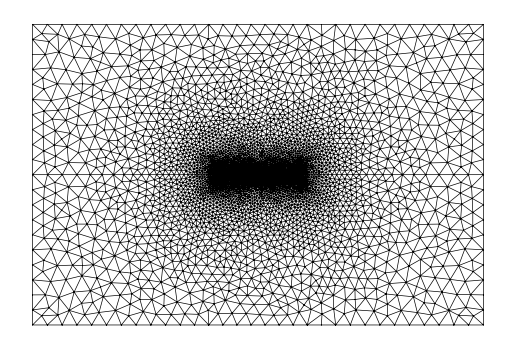

In [3]:
wavelength = 1.55
n_core = n_si(wavelength)
n_clad = n_sio2(wavelength)

w_sim = 6
h_clad = 2
h_box = 2
w_core = 0.5
gap = 0.117  # what we found before
h_core = 0.22

polygons = dict(
    core_1=Polygon(
        [
            (-w_core - gap / 2, -h_core/2),
            (-w_core - gap / 2, h_core/2),
            (-gap / 2, h_core/2),
            (-gap / 2, -h_core/2),
        ]
    ),
    core_2=Polygon(
        [
            (w_core + gap / 2, -h_core/2),
            (w_core + gap / 2, h_core/2),
            (gap / 2, h_core/2),
            (gap / 2, -h_core/2),
        ]
    ),
    clad=Polygon(
        [
            (-w_sim / 2, 0),
            (-w_sim / 2, h_clad),
            (w_sim / 2, h_clad),
            (w_sim / 2, 0),
        ]
    ),
    box=Polygon(
        [
            (-w_sim / 2, 0),
            (-w_sim / 2, -h_box),
            (w_sim / 2, -h_box),
            (w_sim / 2, 0),
        ]
    ),
)

resolutions = dict(
    core_1={"resolution": 0.02, "distance": 2},
    core_2={"resolution": 0.02, "distance": 2},
)

mesh = from_meshio(
    mesh_from_OrderedDict(polygons, resolutions, filename="mesh.msh", default_resolution_max=0.2)
)
mesh.draw().show()

We will now solve for the first two modes of this system and visualize these two modes.

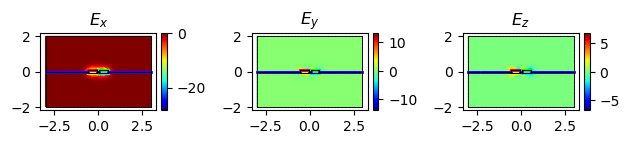

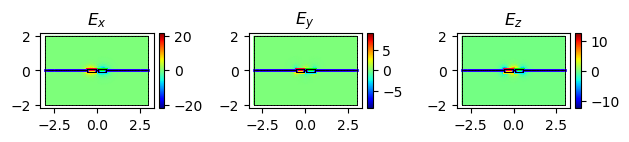

In [4]:
basis0 = Basis(mesh, ElementTriP0(), intorder=4)

epsilon = basis0.zeros() + n_clad**2
epsilon[basis0.get_dofs(elements=("core_1", "core_2"))] = n_core**2
lams_both, basis, xs_both = compute_modes(
    basis0, epsilon, wavelength=wavelength, mu_r=1, num_modes=2
)

plt.close("all")
for xs in xs_both:
    plot_mode(basis, np.real(xs), direction="x")
    plt.show()

And now we simply calculate the coupler length!

Refractive index of symmetric and asymmetric mode: [2.4734993  2.42837495]
Length for 0.5 coupling: 8.587381736123158 µm


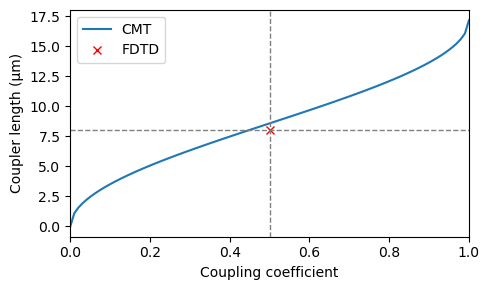

In [5]:
target_c = 0.5

dn = np.abs(np.diff(np.real(lams_both)))
coupling_length = coupler_length(target_c, wavelength, dn)

print("Refractive index of symmetric and asymmetric mode:", np.real(lams_both))
print(f"Length for {target_c} coupling: {coupling_length[0]} µm")

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(np.linspace(0, 1, 100), coupler_length(np.linspace(0, 1, 100), wavelength, dn), label="CMT")
ax.plot([0.5], [8], "rx", label="FDTD")
ax.plot([0, 1], [8, 8], color="gray", ls="--", lw=1)
ax.axvline(0.5, color="gray", ls="--", lw=1)
ax.set_xlabel("Coupling coefficient")
ax.set_ylabel("Coupler length (µm)")
ax.set_xlim([0, 1])
ax.legend()
fig.tight_layout()
plt.show()

We are pretty close but off by 580nm coupler length. This can have any number of reasons, some of them being:
 - Resolution in the FDTD simulations (inaccurate S-parameters)
 - We did not model the adiabatic coupler bend here, which contributes to the effective length of the coupler (this is included in the previous FDTD-based method)
 - Slight differences between the modes calculated by MPB and femwell (due to resolution/meshing)

 All things considered, however, this is a pretty decent result!

## Optimizing a silicon nitride ring filter for critical coupling

Now, we will pick up where we left off in the [ring filter design example](https://github.com/mrbaozi/phodex/blob/main/examples/sax/ring_filter_design.ipynb).

In that example, we determined that for critical coupling to happen, we need a coupling coefficient of 0.006.
Let's use the coupled mode approach to determine the coupler parameters!
Instead of fixing the gap width, we will be sweeping over a range of gap widths and determine the corresponding coupler coefficients.

In [25]:
wavelength = 1.55
n_core = n_si3n4(wavelength)
n_clad = n_sio2(wavelength)

w_sim = 6
h_clad = 2
h_box = 2
w_core = 1.0
h_core = 0.3

gaps = np.linspace(0.1, 0.5, 9)
dns = []
for gap in tqdm(gaps):
    polygons = dict(
        core_1=Polygon(
            [
                (-w_core - gap / 2, -h_core/2),
                (-w_core - gap / 2, h_core/2),
                (-gap / 2, h_core/2),
                (-gap / 2, -h_core/2),
            ]
        ),
        core_2=Polygon(
            [
                (w_core + gap / 2, -h_core/2),
                (w_core + gap / 2, h_core/2),
                (gap / 2, h_core/2),
                (gap / 2, -h_core/2),
            ]
        ),
        clad=Polygon(
            [
                (-w_sim / 2, 0),
                (-w_sim / 2, h_clad),
                (w_sim / 2, h_clad),
                (w_sim / 2, 0),
            ]
        ),
        box=Polygon(
            [
                (-w_sim / 2, 0),
                (-w_sim / 2, -h_box),
                (w_sim / 2, -h_box),
                (w_sim / 2, 0),
            ]
        ),
    )

    resolutions = dict(
        core_1={"resolution": 0.03, "distance": 1},
        core_2={"resolution": 0.03, "distance": 1},
    )

    mesh = from_meshio(
        mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=0.2)
    )

    basis0 = Basis(mesh, ElementTriP0(), intorder=4)

    epsilon = basis0.zeros() + n_clad**2
    epsilon[basis0.get_dofs(elements=("core_1", "core_2"))] = n_core**2
    lams_both, basis, xs_both = compute_modes(
        basis0, epsilon, wavelength=wavelength, mu_r=1, num_modes=2
    )

    dns.append(np.abs(np.diff(np.real(lams_both)))[0])
dns = np.array(dns)

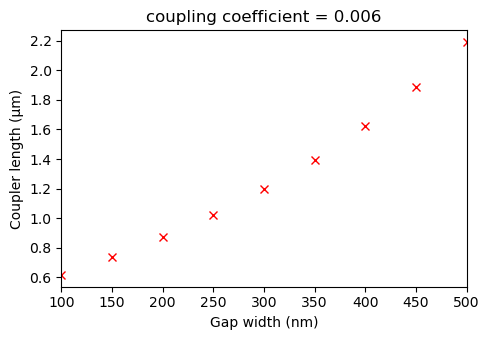

In [35]:
target_c = 0.006
lengths = coupler_length(target_c, wavelength, dns)

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))
ax.plot(1000 * gaps, lengths, "rx")
ax.set_xlabel("Gap width (nm)")
ax.set_ylabel("Coupler length (µm)")
ax.set_title(f"coupling coefficient = {target_c}")
ax.set_xlim([1000 * gaps[0], 1000 * gaps[-1]])
fig.tight_layout()
plt.show()